**Classification of Agroclimates in Kansas**

Sarah Sexton-Bowser and Andres Patrignani<br>
Spring 2022

In [457]:
# Import Modules

# Data handling modules
import matplotlib as plt
import pandas as pd
import numpy as np
import geopandas as gpd #reference for Geopandas https://geopandas.org/mapping.html 

# Statistic modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cluster modules
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Plotting and mapping modules
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import DivergingNorm
%matplotlib inline
import cartopy.crs as ccrs
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

**Load data pre-processed data stored on Github**

In [309]:
# load feature data
URL = 'https://raw.githubusercontent.com/sarahannbowser/KS_agro_climatic_zones/main/data/feature_data.csv'
features = pd.read_csv(URL)
features=features.set_index('geometry') #geometry is maintained as the index for use in merging to map shape file

In [310]:
features = features.drop(columns=['SR', 'silt','elevation']) # drop highly coorelated features  
names=features.columns # obtain names of the features for future plotting

# print a description of the data
print('Summary of the data features.')
round(features.describe(),2)

Summary of the data features.


,vapor pressure,precipitation,sand,clay,temp,water storage
count,12190.00,12190.00,12190.00,12190.00,12190.00,12190.00
mean,16.41,733.51,22.01,28.25,12.64,16.75
std,2.11,202.49,14.05,6.60,0.98,2.65
min,12.00,412.00,8.48,7.38,11.00,8.06
25%,15.00,550.00,13.24,23.13,12.00,14.76
50%,17.00,713.00,16.89,27.48,13.00,16.83
75%,18.00,901.00,23.83,33.80,13.00,19.24
max,21.00,1170.00,82.82,41.64,15.00,21.30


**Standardize the Data** </br>
The features of Kansas agroclimates in this feature set are annual mean max daily vapor pressure, annual mean precipitation, % of sand, % of clay, PAWC, mean annual temperature. Data was obtained from PRISM Climate Group and USDA NASS STATSGO2 </br>

The data was standardized with Scikit-learn StandardScale, z-score normalization, to account for the various units and scales of each feature in the dataset. 

In [322]:
scaler= StandardScaler()
X= scaler.fit_transform(features)

**Are all the features descriptive attributes of the agroclimate zones? Are any features correlated?**

We will explore the data in a couple ways</br> 1) a cumulative explaination PCA graph </br> 2) a heatmap of the PCA compontents </br> 3) a heatmap of the coorelation matrix 

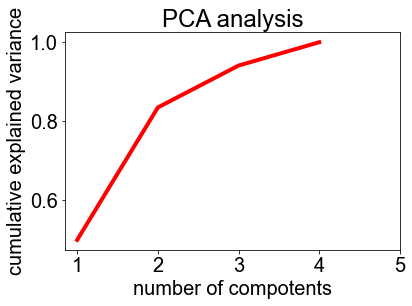

In [375]:
# Let's evaluate how many components are descriptive for 95% of the variability
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '20'

pca=PCA(.95).fit(X) 
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=4, color='red')
plt.xlabel('number of compotents')
plt.ylabel('cumulative explained variance')

plt.xticks([0,1,2,3,4],['1','2','3','4','5'])
plt.title('PCA analysis')
plt.show()

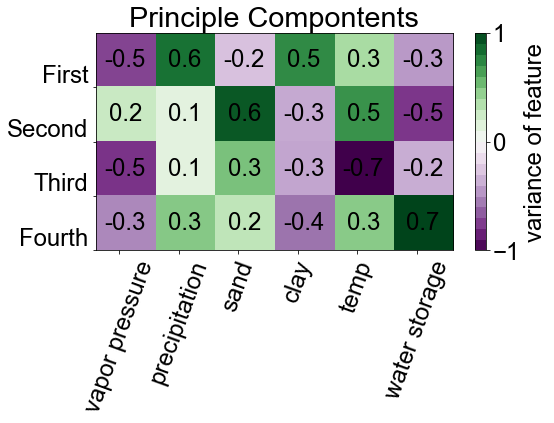

In [325]:
# Plot a matrix of the PCA compotents 
fig = plt.figure(figsize=(8, 4))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '24'
data=pca.components_
plt.imshow(pca.components_, interpolation = 'none', cmap = 'PRGn', aspect='auto')
#ax.imshow(data)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, "{:.1f}".format(data[i,j]), ha="center", va="center")
feature_names = names
plt.gca().set_xticks(np.arange(-.1, 5));
plt.gca().set_yticks(np.arange(0.5, 4));
plt.gca().set_xticklabels(feature_names, rotation=70, ha='center', fontsize=24);
plt.gca().set_yticklabels(['First', 'Second','Third', 'Fourth'], va='bottom', fontsize=24);
plt.gca().set_title('Principle Compontents')
#plt.gca().set_ylabel('compontent')

norm = mpl.colors.Normalize(vmin=-1,vmax=1)
sm = plt.cm.ScalarMappable(cmap='PRGn', norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(-1,1,3), 
             boundaries=np.arange(-1,1.1,.1), label='variance of feature')

plt.show()

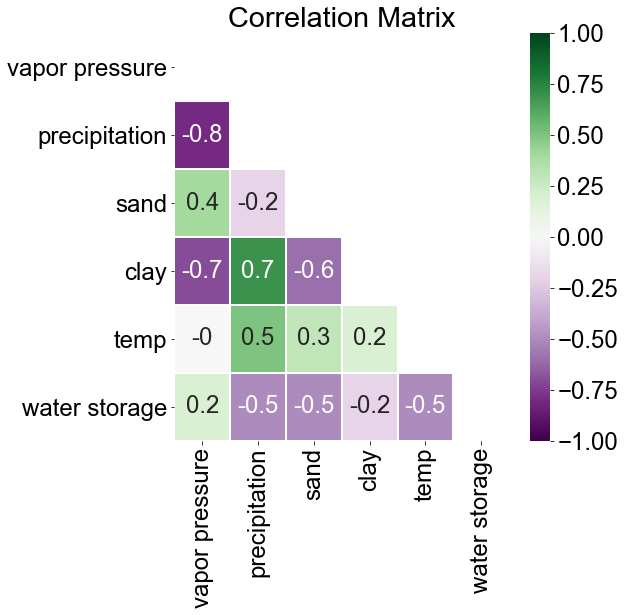

In [326]:
# Correlation Matrix
X_cor=pd.DataFrame(X, columns=names) # convert back to a pandas for use of corr() function
correlation = X_cor.corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(7.5,7.5)),
sns.heatmap(round(X_cor.corr(),1),
            vmin=-1, vmax=1,
            linewidths=1,
            cmap='PRGn',
            annot=True,
            mask=mask,
            label='test');

plt.title('Correlation Matrix')
plt.show()

**We will transform the data to four PCAs**

In [327]:
# We have coorelation in the data, and our PCA chart shows that 95% of our desciptive ability is in 4 compontents

# We will use PCA to transform our data to a PCA with four compotents 
print('Orginal Data Shape with all Features')
print(X.shape)

# Transform Data
pca=PCA(.95).fit(X)
X=pca.transform(X) 
print('Data shape after PCA with all Features')
print(X.shape)

Orginal Data Shape with all Features
(12190, 6)
Data shape after PCA with all Features
(12190, 4)


# Cluster analysis with Kmeans 

The classification of zones is done with a classic clustering algorithum, kmeans. Two metrics are used to evaluate the model performance, Silhouette score and Calinski harabasz.

The metrics of silhouette and calinski harabasz score are used to evaluate performance of the clusters, in terms of inter and intra cluster density and dispersion. 

Silhouette score is used to determine similar an observation is to its assigned cluster relative to other clusters. The score is a mean measurement of all samples and a score of 1 with a bottom range of -1.  

Calinski harabasz is a variance ratio used to measure how similar a cluster is compared compared to the seperation of other clusters. This measure is a sum, and higher numbers indicate better performance. 

In [270]:
# KMeans loop to evaluate various cluster numbers
print ('Performance of Kmeans models with different clusters')
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13,14,30]
for n_clusters in range_n_clusters:
    clusters = KMeans(n_clusters)            
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X, cluster_labels)
    print("For", n_clusters, "clusters",
          "silhouette score is:", round(silhouette_avg,2),
          "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Kmeans models with different clusters
For 2 clusters silhouette score is: 0.54 and the calinski harabasz score is: 8198.48
For 3 clusters silhouette score is: 0.67 and the calinski harabasz score is: 11348.67
For 4 clusters silhouette score is: 0.53 and the calinski harabasz score is: 9612.02
For 5 clusters silhouette score is: 0.49 and the calinski harabasz score is: 8807.9
For 6 clusters silhouette score is: 0.48 and the calinski harabasz score is: 8380.2
For 7 clusters silhouette score is: 0.48 and the calinski harabasz score is: 8126.67
For 8 clusters silhouette score is: 0.48 and the calinski harabasz score is: 7771.16
For 9 clusters silhouette score is: 0.48 and the calinski harabasz score is: 7504.96
For 10 clusters silhouette score is: 0.48 and the calinski harabasz score is: 7302.57
For 11 clusters silhouette score is: 0.48 and the calinski harabasz score is: 7065.2
For 12 clusters silhouette score is: 0.48 and the calinski harabasz score is: 6822.64
For 13 clus

# What do the various clusters look like? 
Here we merge the cluster prediction back to the georeferenced map of Kansas. And load a shape file for the state and counties. 

In [362]:
# Shape file of State of Kansas
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp' # state shape file. 
kansas = gpd.read_file(fp)
ks_map = kansas.NAME.isin(['Kansas']) 
ks_map = kansas[ks_map].loc[0:]

# County shape file, use for county lines
fp= 'C:/Users/sarahann.USERS/Desktop/code/us_county/US_County_Boundaries.shp' # county file

map_county = gpd.read_file(fp)
# Delete Non-contingous US counties 
ks_county = map_county.STATE.isin(['Kansas'])  
map_county = map_county[ks_county].loc[0:]


# shape file of feature data
map_df = gpd.read_file('C:/Users/sarahann.USERS/Desktop/code/CSI_732/seminar/feature_data.shape') 
map_df= map_df.set_axis(['elevation', 'vapor pressure', 'precip', 'sand', 'clay', 'silt', 'sr', 'temp', 'water capacity', 'geometry'], axis=1)
round(map_df.head(2),2)

,elevation,vapor pressure,precip,sand,clay,silt,sr,temp,water capacity,geometry
0,357.0,13.0,829.0,22.65,32.19,45.16,21.0,11.0,15.64,"POLYGON ((-96.17263 40.00056, -96.15440 40.000..."
1,267.0,13.0,872.0,14.12,27.76,58.12,21.0,12.0,20.80,"POLYGON ((-95.43601 40.00007, -95.43599 40.000..."


In [348]:
# Run Clusters model for each of the models, with best performning parameters
clusters = KMeans(n_clusters=3)            
kmean_3_cluster = clusters.fit_predict(X)

clusters = KMeans(n_clusters=6)            
kmean_6_cluster = clusters.fit_predict(X)

clusters = KMeans(n_clusters=7)            
kmean_7_cluster = clusters.fit_predict(X)

clusters = KMeans(n_clusters=8)            
kmean_8_cluster = clusters.fit_predict(X)

clusters = KMeans(n_clusters=9)            
kmean_9_cluster = clusters.fit_predict(X)

In [365]:
# Merge the cluster labels for each clustering algorithum
# Add one to each of the clusters, so cluster ranges start at 1 instead of 0
map_df['kmeans_3']=kmean_3_cluster+1 
map_df['kmeans_6']=kmean_6_cluster+1
map_df['kmeans_7']=kmean_7_cluster+1
map_df['kmeans_8']=kmean_8_cluster+1
map_df['kmeans_9']=kmean_9_cluster+1

map_df.head(2)

,elevation,vapor pressure,precip,sand,clay,silt,sr,temp,water capacity,geometry,kmeans_3,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10,kmeans_12,kmeans_30
0,357.0,12.999999,828.999955,22.649809,32.185774,45.164416,20.999999,10.999999,15.637290,"POLYGON ((-96.17263 40.00056, -96.15440 40.000...",2,2,4,1,5,3,6,15
1,267.0,12.999999,871.999953,14.118232,27.761514,58.120256,20.999999,11.999999,20.804992,"POLYGON ((-95.43601 40.00007, -95.43599 40.000...",2,2,6,1,5,3,4,8


**Three clusters perform best and illustrate macro-environmental zones.** 

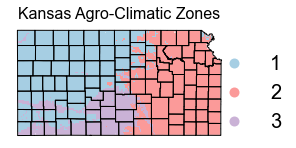

In [445]:
plt.figure(figsize=(4,5), constrained_layout=True) 
ax = plt.axes(projection=ccrs.PlateCarree())
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 20
 
plt.title('Kansas Agro-Climatic Zones', fontsize=16)

cmap = mpl.colors.ListedColormap(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6'])
plot=map_df.plot(column='kmeans_3', cmap=cmap, categorical=True,legend=True, ax=ax, 
                 legend_kwds=dict(bbox_to_anchor=(1.3,.9), frameon=False))

ks_map.plot(ax=ax, color='none', edgecolor='white', linewidths =1)
map_county.plot(ax=ax, color='none', edgecolor='black', linewidths =1)
plt.box(False)

plt.show()

**Here we visualize clusters 6-9 to evaluate suitability in representing the agro-climatic zones of Kansas.** 

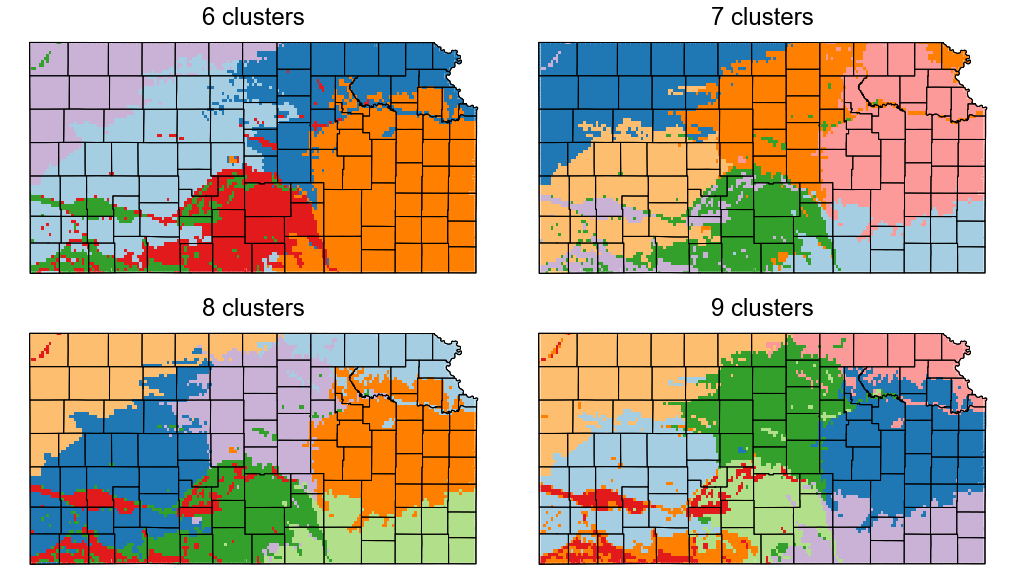

In [446]:
fig, axs = plt.subplots(2,2, figsize=(14,8), constrained_layout=True) 

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 20

# First Plot
plot = map_df.plot(column=map_df.kmeans_6, 
            cmap= cmap,  
            ax=axs[0,0], 
            ) 
axs[0,0].set_title('6 clusters')

# Second Plot
plot = map_df.plot(column=map_df.kmeans_7, 
            cmap= cmap,  
            ax=axs[0,1], 
            ) 
axs[0,1].set_title('7 clusters')

# Third Plot
plot = map_df.plot(column=map_df.kmeans_8, 
            cmap= cmap,  
            ax=axs[1,0], 
            ) 
axs[1,0].set_title('8 clusters')

# Fourth Plot
plot = map_df.plot(column=map_df.kmeans_9, 
            cmap= cmap,  
            ax=axs[1,1], 
            ) 
axs[1,1].set_title('9 clusters')

axs[0,0].set_axis_off()
axs[0,1].set_axis_off()
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()

# Plot boundaries 
ks_map.plot(ax=axs[0,0], color='none', edgecolor='black')
map_county.plot(ax=axs[0,0], color='none', edgecolor='black', linewidths =1)
ks_map.plot(ax=axs[0,1], color='none', edgecolor='black')
map_county.plot(ax=axs[0,1], color='none', edgecolor='black', linewidths =1)
ks_map.plot(ax=axs[1,0], color='none', edgecolor='black')
map_county.plot(ax=axs[1,0], color='none', edgecolor='black', linewidths =1)
ks_map.plot(ax=axs[1,1], color='none', edgecolor='black')
map_county.plot(ax=axs[1,1], color='none', edgecolor='black', linewidths =1)

plt.show()

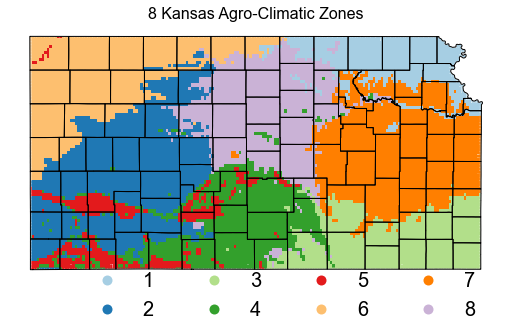

In [447]:
plt.figure(figsize=(7,9), constrained_layout=True) 
ax = plt.axes(projection=ccrs.PlateCarree())
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 20
 
plt.title('8 Kansas Agro-Climatic Zones', fontsize=16)

plot=map_df.plot(column='kmeans_8', cmap=cmap, categorical=True,legend=True, ax=ax, 
                 legend_kwds=dict(bbox_to_anchor=(.55,-.22), frameon=False, ncol=4, loc='lower center'))

ks_map.plot(ax=ax, color='none', edgecolor='white', linewidths =1)
map_county.plot(ax=ax, color='none', edgecolor='black', linewidths =1)
plt.box(False)

plt.show()

In [454]:
kmean_cluster = map_df.groupby(by='kmeans_8').agg({'vapor pressure':"mean", 'precip':"mean", 'sand':"mean",'clay':"mean", 'temp':"mean", 'water capacity':"mean"})


print("Cluster features with 8 agro climatic zones")
                                              
print(tabulate(round(kmean_cluster,0), headers=['VPD hPa', 'Precip mm', 'Sand%', 'Clay%','Temp C', 'PAWC cm']))


Cluster features with 8 agro climatic zones
      VPD hPa    Precip mm    Sand%    Clay%    Temp C    PAWC cm
--  ---------  -----------  -------  -------  --------  ---------
 1         14          870       20       31        12         16
 2         19          528       18       26        12         19
 3         15         1029       17       35        14         15
 4         18          710       45       21        14         15
 5         19          547       63       15        13         12
 6         17          529       14       23        11         20
 7         14          957       14       37        13         15
 8         16          720       20       28        13         18


**Let us look at the deviation of each feature for the clusters generated with 8 zones as a percent of the state mean for the respective feature.**

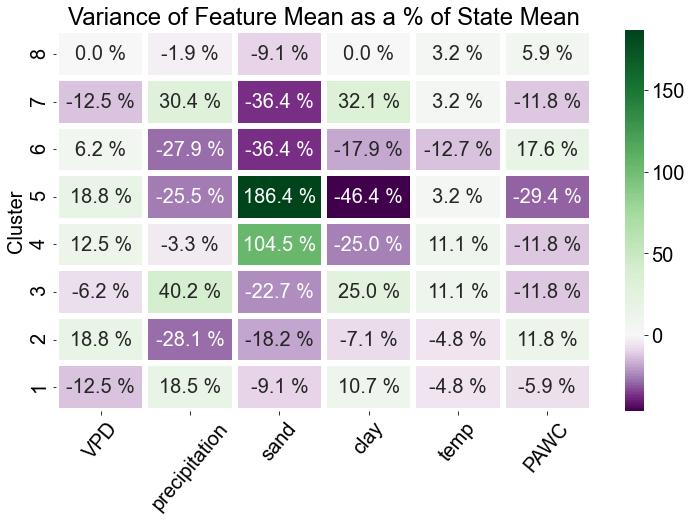

In [460]:
# This data was processed from the table above.
data = pd.read_csv('C:/Users/sarahann.USERS/Desktop/code/CSI_732/seminar/cluster_features_means.csv')
data=data.set_index('Cluster')
data=data*100 # convert for %
divnorm = DivergingNorm(vmin=data.min().min(), vcenter=0, vmax=data.max().max())
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 20

plt.figure(figsize=(12,7)),
res= sns.heatmap(round(data,2),
            fmt='.1f',
          #  vcenter=0,
         #   cbar_kws={'format': '%.00f%%'},
            norm=divnorm,
            linewidths=5,
            cmap='PRGn',
            annot=True,
            label='test');

res.invert_yaxis()
res.set_xticklabels(res.get_xticklabels(),rotation = 50)
for t in res.texts: t.set_text(t.get_text() + " %")

plt.title('Variance of Feature Mean as a % of State Mean')
plt.show()

# Citations 
PRISM Climate Group, Oregon State University. (1981-2010). 30-Year Normals United States Average Monthly Precipitation. http://prism.oregonstate.edu </br>
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. </br>
Soil Survey Staff, Natural Resources Conservation Service, United States Department of Agriculture. U.S. General Soil Map (STATSGO2). Available online at https://sdmdataaccess.sc.egov.usda.gov.</br>